In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadd,
    RandRotate90d,
    CenterSpatialCropd,
    ResizeWithPadOrCropd,
    Flipd,
    Rotate90d,
    RandAffined,
    RandGaussianNoised,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    pad_list_data_collate
)

import numpy as np
import torch

In [2]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-50,
            a_max=100,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # Spacingd(keys=["image", "label"], pixdim=(2.0, 2.0, 0.1), mode=("bilinear", "nearest")),
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        # CenterSpatialCropd(keys=['image', 'label'], roi_size=(512,512,12)),
        # Resize(spatial_size=(400, 400, 12)),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(512, 512, 16)),
        Rotate90d(keys=["image", "label"], k=1),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 16),
            pos=1,
            neg=1,
            num_samples=8,
            image_key="image",
            image_threshold=0,
        ),
        # RandAffined(
        #     keys=["image", "label"],
        #     mode=("bilinear", "nearest"),
        #     prob=1.0,
        #     spatial_size=(512, 512, 16),
        #     translate_range=(40, 40, 2),
        #     rotate_range=(np.pi / 36, np.pi / 36, np.pi / 4),
        #     scale_range=(0.15, 0.15, 0.15),
        #     padding_mode="border",
        # ),
        # RandGaussianNoised(keys=["image"], prob=0.10, std=0.1),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        # CenterSpatialCropd(keys=['image', 'label'], roi_size=(352,352,16))
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(keys=["image", "label"], pixdim=(2.0, 2.0, 0.1), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-50,
            a_max=100,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        # Resize(spatial_size=(400, 400, 12)),
        ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=(512, 512, 16)),
        Rotate90d(keys=["image", "label"], k=1),
        # CenterSpatialCropd(keys=['image', 'label'], roi_size=(352,352,16)),
        # Flipd(keys=["image", "label"], spatial_axis=[0]),
    ]
)

d:\anaconda3\envs\pytorch\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [3]:
data_dir = r"F:\sth\23Fall\fcpro\brain_image2"
split_json = "./dataset.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=8,
    cache_rate=1.0,
    num_workers=0,
)
device_ids = [i for i in range(torch.cuda.device_count())]
train_loader = DataLoader(train_ds, batch_size=1 * len(device_ids), shuffle=True, num_workers=0, pin_memory=True,drop_last=True, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1* len(device_ids), shuffle=False, num_workers=0, pin_memory=True, collate_fn=pad_list_data_collate)

Loading dataset:   0%|          | 0/8 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]


image shape: torch.Size([1, 512, 512, 16]), label shape: torch.Size([1, 512, 512, 16])


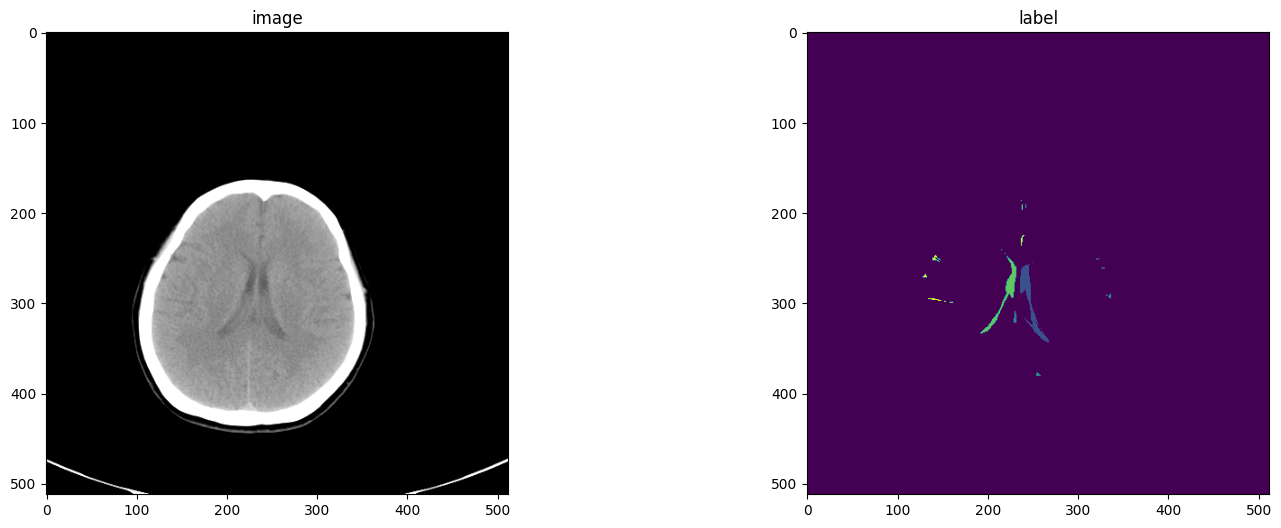

In [4]:
slice_map = {
    "brain_272_0000.nii.gz": 8,
}
case_num = 0
# print(val_ds[case_num])
img_name = os.path.split(val_ds[case_num]['image'].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [5]:
import torch.nn as nn



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=5,
    img_size=(96, 96, 16),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

root_dir = "./run"
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [6]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(device_ids[0]), batch["label"].cuda(device_ids[0]))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 16), 8, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(device_ids[0]), batch["label"].cuda(device_ids[0]))
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 30000 # 2000
eval_num = 500 # 50
post_label = AsDiscrete(to_onehot=5)
post_pred = AsDiscrete(argmax=True, to_onehot=5)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (500 / 30000 Steps) (loss=1.60646):  91%|█████████▏| 157/172 [02:59<02:44, 10.96s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2055712193250656 Current Avg. Dice: 0.2055712193250656


Training (1000 / 30000 Steps) (loss=1.29215):  82%|████████▏ | 141/172 [02:44<05:30, 10.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.25200051069259644 Current Avg. Dice: 0.25200051069259644


Training (1500 / 30000 Steps) (loss=1.03779):  73%|███████▎  | 125/172 [02:30<08:17, 10.58s/it]

Model Was Saved ! Current Best Avg. Dice: 0.26731759309768677 Current Avg. Dice: 0.26731759309768677


Training (2000 / 30000 Steps) (loss=0.93539):  63%|██████▎   | 109/172 [02:15<11:22, 10.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2821037173271179 Current Avg. Dice: 0.2821037173271179


Training (2500 / 30000 Steps) (loss=0.89640):  54%|█████▍    | 93/172 [02:02<15:17, 11.61s/it]

Model Was Saved ! Current Best Avg. Dice: 0.298379123210907 Current Avg. Dice: 0.298379123210907


Training (3000 / 30000 Steps) (loss=0.85086):  45%|████▍     | 77/172 [01:44<16:36, 10.49s/it]

Model Was Saved ! Current Best Avg. Dice: 0.40583372116088867 Current Avg. Dice: 0.40583372116088867


Training (3500 / 30000 Steps) (loss=0.95279):  35%|███▌      | 61/172 [01:28<19:49, 10.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4296500086784363 Current Avg. Dice: 0.4296500086784363


Training (4000 / 30000 Steps) (loss=0.82641):  26%|██▌       | 45/172 [01:12<22:21, 10.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.43802985548973083 Current Avg. Dice: 0.43802985548973083


Training (4500 / 30000 Steps) (loss=0.80460):  17%|█▋        | 29/172 [00:58<25:11, 10.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4408009648323059 Current Avg. Dice: 0.4408009648323059


Training (5000 / 30000 Steps) (loss=0.73300):   8%|▊         | 13/172 [00:43<28:15, 10.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.45060476660728455 Current Avg. Dice: 0.45060476660728455


Training (5500 / 30000 Steps) (loss=0.78616):  98%|█████████▊| 169/172 [03:03<00:31, 10.50s/it]

Model Was Saved ! Current Best Avg. Dice: 0.49523982405662537 Current Avg. Dice: 0.49523982405662537


Training (6000 / 30000 Steps) (loss=0.67707):  89%|████████▉ | 153/172 [02:48<03:20, 10.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5020974278450012 Current Avg. Dice: 0.5020974278450012


Training (6500 / 30000 Steps) (loss=0.72301):  80%|███████▉  | 137/172 [02:35<06:05, 10.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5020974278450012 Current Avg. Dice: 0.5000311136245728


Training (7000 / 30000 Steps) (loss=0.75663):  70%|███████   | 121/172 [02:20<08:58, 10.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5644749402999878 Current Avg. Dice: 0.5644749402999878


Training (7500 / 30000 Steps) (loss=0.68134):  61%|██████    | 105/172 [02:07<11:56, 10.69s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5809929370880127 Current Avg. Dice: 0.5809929370880127


Training (8000 / 30000 Steps) (loss=0.77485):  52%|█████▏    | 89/172 [01:51<14:33, 10.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5842254757881165 Current Avg. Dice: 0.5842254757881165


Training (8500 / 30000 Steps) (loss=0.69081):  42%|████▏     | 73/172 [01:37<17:21, 10.52s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5932625532150269 Current Avg. Dice: 0.5932625532150269


Training (9000 / 30000 Steps) (loss=0.57412):  33%|███▎      | 57/172 [01:22<19:55, 10.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5932625532150269 Current Avg. Dice: 0.5895284414291382


Training (9500 / 30000 Steps) (loss=0.72689):  24%|██▍       | 41/172 [01:08<23:00, 10.54s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5967512726783752 Current Avg. Dice: 0.5967512726783752


Training (10000 / 30000 Steps) (loss=0.72732):  15%|█▍        | 25/172 [00:54<25:52, 10.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6037954688072205 Current Avg. Dice: 0.6037954688072205


Training (10500 / 30000 Steps) (loss=0.56925):   5%|▌         | 9/172 [00:40<29:47, 10.96s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6070736050605774 Current Avg. Dice: 0.6070736050605774


Training (11000 / 30000 Steps) (loss=0.62757):  96%|█████████▌| 165/172 [03:00<01:14, 10.64s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6071916818618774 Current Avg. Dice: 0.6071916818618774


Training (11500 / 30000 Steps) (loss=0.66526):  87%|████████▋ | 149/172 [02:45<04:02, 10.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6071916818618774 Current Avg. Dice: 0.6032554507255554


Training (12000 / 30000 Steps) (loss=0.65182):  77%|███████▋  | 133/172 [02:31<06:47, 10.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6071916818618774 Current Avg. Dice: 0.5974065661430359


Training (12500 / 30000 Steps) (loss=0.75756):  68%|██████▊   | 117/172 [02:15<09:27, 10.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6071916818618774 Current Avg. Dice: 0.5978001356124878


Training (13000 / 30000 Steps) (loss=0.76717):  59%|█████▊    | 101/172 [02:01<12:17, 10.39s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6138178110122681 Current Avg. Dice: 0.6138178110122681


Training (13500 / 30000 Steps) (loss=0.62892):  49%|████▉     | 85/172 [01:48<15:11, 10.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6138178110122681 Current Avg. Dice: 0.6086055040359497


Training (14000 / 30000 Steps) (loss=0.67055):  40%|████      | 69/172 [01:33<17:56, 10.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6138178110122681 Current Avg. Dice: 0.6076064109802246


Training (14500 / 30000 Steps) (loss=0.62222):  31%|███       | 53/172 [01:19<20:45, 10.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6138178110122681 Current Avg. Dice: 0.603232741355896


Training (15000 / 30000 Steps) (loss=0.61560):  22%|██▏       | 37/172 [01:04<23:14, 10.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6138178110122681 Current Avg. Dice: 0.6121338605880737


Training (15500 / 30000 Steps) (loss=0.62000):  12%|█▏        | 21/172 [00:50<26:18, 10.46s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6147109270095825 Current Avg. Dice: 0.6147109270095825


Training (16000 / 30000 Steps) (loss=0.76267):   3%|▎         | 5/172 [00:36<34:18, 12.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6177313923835754 Current Avg. Dice: 0.6177313923835754


Training (16500 / 30000 Steps) (loss=0.82198):  94%|█████████▎| 161/172 [02:56<01:54, 10.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6177313923835754 Current Avg. Dice: 0.6114506721496582


Training (17000 / 30000 Steps) (loss=0.55220):  84%|████████▍ | 145/172 [02:42<04:42, 10.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6177313923835754 Current Avg. Dice: 0.6113210916519165


Training (17500 / 30000 Steps) (loss=0.65830):  75%|███████▌  | 129/172 [02:28<07:28, 10.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6177313923835754 Current Avg. Dice: 0.6089877486228943


Training (17624 / 30000 Steps) (loss=0.62517):  47%|████▋     | 81/172 [01:13<01:30,  1.00it/s]

[0.19595299661159515, 0.22811920940876007, 0.29186680912971497, 0.30148178339004517, 0.4097909927368164, 0.4458845257759094, 0.4761233329772949, 0.5563766360282898, 0.6065319776535034, 0.6107920408248901, 0.6280866861343384, 0.6354818940162659, 0.6494876146316528, 0.6396897435188293, 0.6542342305183411, 0.6503233909606934, 0.65642911195755, 0.6580517292022705, 0.6592726707458496, 0.6613168716430664, 0.6584131121635437, 0.66627037525177, 0.6648315191268921, 0.6659995317459106, 0.66603022813797, 0.6687301993370056, 0.6692132949829102, 0.6701905727386475, 0.6676666736602783, 0.6627170443534851, 0.6715517640113831, 0.6713098287582397, 0.6679916381835938, 0.6649607419967651, 0.6604234576225281, 0.6672571897506714, 0.6635393500328064, 0.6704288721084595, 0.6616403460502625, 0.6533085703849792, 0.668599009513855, 0.6667630076408386, 0.6474339365959167, 0.6666936874389648, 0.6608313322067261, 0.6596171259880066, 0.6581613421440125, 0.6595466732978821, 0.664583683013916, 0.6396064758300781, 0.6

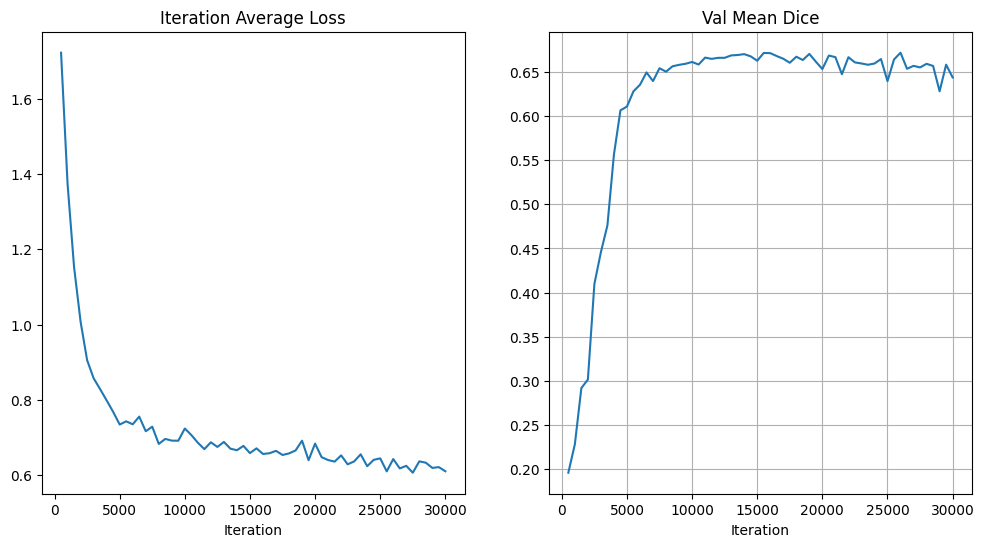

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
print(metric_values)
y = metric_values
plt.grid(True)
plt.xlabel("Iteration")
plt.yticks(np.arange(0.0, 0.8, 0.05))
plt.plot(x, y)
plt.show()

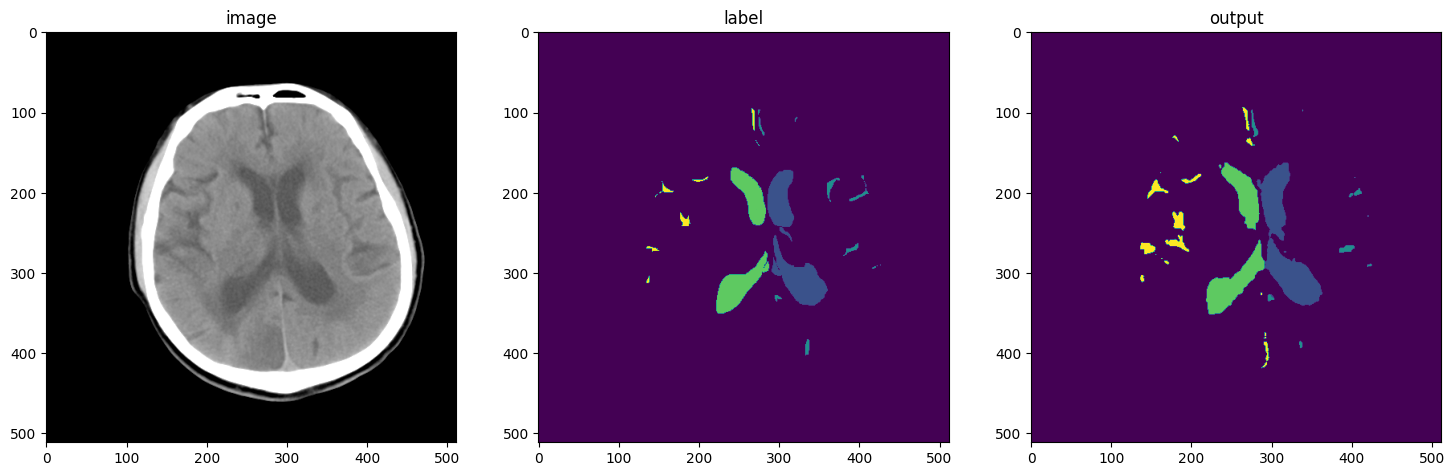

In [ ]:
slice_map = {
    "brain_250_0000.nii.gz": 8,
    "brain_231_0000.nii.gz": 11,

}
case_num = 3
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 16), 8, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()